In [1]:
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym
from IPython.display import clear_output
import numpy as np
from collections import defaultdict
import wandb

In [2]:
def test_policy(policy=None, fps=1):
    '''
        Visually evaluate a police, fallback to random action
    '''

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()[0]

    # iterate
    while True:

        # Select next action
        if policy is None:
            # Sample random action if no policy is given
            action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
        else:
            # Check if state is in policy
            if obs not in policy:
                # If not, sample random action
                action = env.action_space.sample()
            else:
                # Use policy to determine the next action
                action = policy[obs]

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        clear_output(wait=True)
        sys.stdout.write(env.render())
        print('Action: ', action)
        print('Observation: ', obs)
        print('Reward: ', reward)
        time.sleep(1/fps) # FPS
        

        # If player is dead break
        if done:
            break

    env.close()


In [10]:
test_policy(policy=policy,fps=20)

Text Flappy Bird!
Score: 3
----------------------
[      @  |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=3,dy=-3)
Action:  1
Observation:  (3, -3)
Reward:  1


KeyboardInterrupt: 

In [3]:
# Generate episode data

def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()[0] # fix new version
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, info, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [4]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05, wandb_tracking=False):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # Login to wandb
    if wandb_tracking:
        wandb.login()
        wandb.init(
            project="flappy-bird_rl",
            config = {"alpha": alpha, "gamma": gamma, "eps_start": eps_start, "eps_decay": eps_decay, "eps_min": eps_min}
        )

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

        # Log to wandb
        if wandb_tracking:
            reward = np.sum([x[2] for x in episode])
            wandb.log({"reward": reward})

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [8]:
# obtain the estimated optimal policy and action-value function
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

policy, Q = mc_control(env, 500000, 0.02, wandb_tracking=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


reward,▁▁▁▁▁▂▂▁▂▂▂▂▁▂▂▂▃▂▁▂▆▂▆▅▂▄▃▃▃▁▃█▅▄▄▅▂▃▅▄
reward,73


Episode 500000/500000.

In [9]:
# save the policy to the current directory
np.save('MC_policy_500K.npy', policy)

In [13]:
# Load the policy
new_policy = np.load('MC_policy_500K.npy', allow_pickle=True).item()

# Test the policy
test_policy(policy=new_policy,fps=20)

Text Flappy Bird!
Score: 18
----------------------
[   |         |      ]
[   |         |      ]
[             |      ]
[             |      ]
[             |      ]
[      @      |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |                ]
[   |                ]
[   |                ]
[   |                ]
[   |         |      ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=7,dy=-6)
Action:  0
Observation:  (7, -6)
Reward:  1


KeyboardInterrupt: 

In [10]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items()) # use the max value of the action-value function since it is the optimal policy


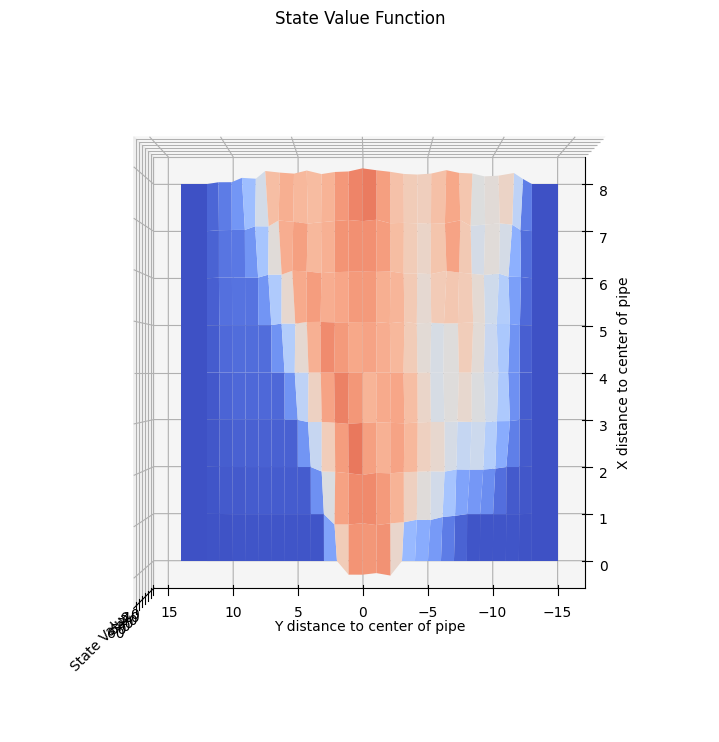

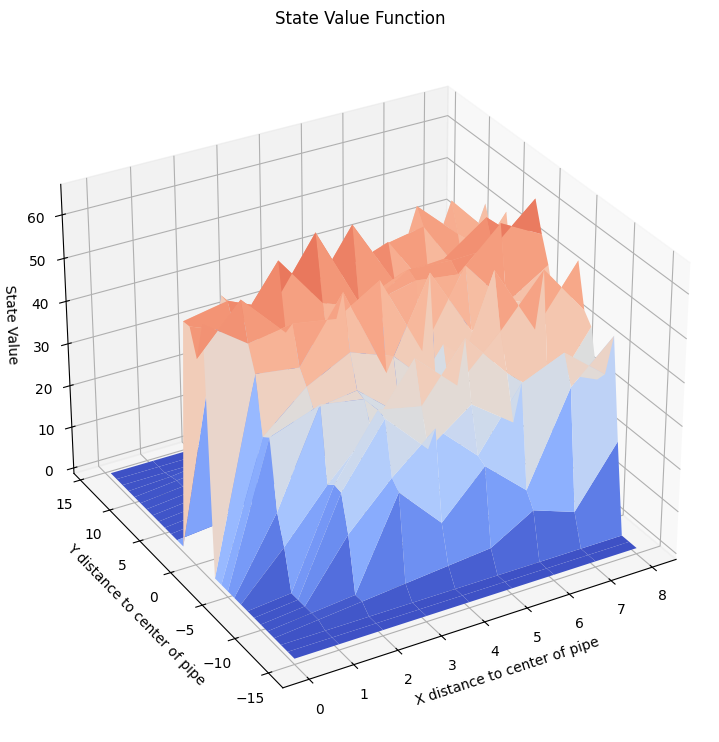

In [32]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_flappy_values(V):

    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax,top_view=False):
        x_range = np.arange(0, 9)
        y_range = np.arange(-15, 15)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=70)
        ax.set_xlabel('X distance to center of pipe')
        ax.set_ylabel('Y distance to center of pipe')
        ax.set_zlabel('State Value')
        if top_view:
            ax.view_init(90,180)
        else:
            ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State Value Function')
    get_figure(ax, top_view=True)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State Value Function')
    get_figure(ax, top_view=False)

    plt.show()

plot_flappy_values(V)